# Load your data

Before finetuning a pretrained model of the experiments we provide in our repository (or precomputed and provided [here](https://datacloud.hhi.fraunhofer.de/nextcloud/s/NCjYws3mamLrkKq)), first load your custom 100 Hz sampled 12-lead ECG signal data `X` of shape `[N,L,12]` in Millivolts (mV) and multi-hot encoded labels `y` of shape `[N,C]` as numpy arrays, where `C` is the number of classes and `N` the number of total samples in this dataset. Although PTB-XL comes with fixed `L=1000` (i,e. 10 seconds), it is not required to be fixed, **BUT** the shortest sample must be longer than `input_size` of the specific model (e.g. 2.5 seconds for our fastai-models).

For proper tinetuning split your data into four numpy arrays: `X_train`,`y_train`,`X_val` and `y_val`

### Example: finetune model trained on all (71) on superdiagnostic (5)
Below we provide an example for loading [PTB-XL](https://physionet.org/content/ptb-xl/1.0.1/) aggregated at the `superdiagnostic` level, where we use the provided folds for train-validation-split:

In [ ]:
!pip install wget wfdb tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00


In [ ]:
import wget
import numpy as np
import os
import zipfile
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
!wget https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip

os.mkdir("./data/")


with zipfile.ZipFile("./ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip", 'r') as zip_ref:
    zip_ref.extractall("./data/")

--2023-02-08 08:07:05--  https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1842722380 (1.7G) [application/zip]
Saving to: ‘ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip’

ptb-xl-a-large-publ 100%[===================>]   1.72G  1.76MB/s    in 14m 26s 

2023-02-08 08:21:31 (2.03 MB/s) - ‘ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip’ saved [1842722380/1842722380]



In [ ]:
!pip install GitPython
from git import Repo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.5 MB/s eta 0:00:00


In [ ]:
HTTPS_REMOTE_URL = 'https://github.com/Bsingstad/ecg_ptbxl_benchmarking.git'
DEST_NAME = 'github_repo'

In [ ]:
Repo.clone_from(HTTPS_REMOTE_URL, DEST_NAME)

<git.repo.base.Repo '/content/github_repo/.git'>

In [ ]:
from github_repo.code import *
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from github_repo.code.utils import utils

sampling_frequency=100
datafolder='./data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
task='all'
outputfolder='./github_repo/output/'


# Load PTB-XL data
data, raw_labels = utils.load_dataset(datafolder, sampling_frequency)
# Preprocess label data
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
# Select relevant data and convert to one-hot
#data, labels, Y, _ = utils.select_data(data, labels, task, min_samples=0, outputfolder=outputfolder)

data, labels, Y, _ = utils.select_data(data, labels, task, min_samples=0, outputfolder=outputfolder)

# 1-9 for training 
X_train = data[labels.strat_fold < 10]
y_train = Y[labels.strat_fold < 10]
# 10 for validation
X_val = data[labels.strat_fold == 10]
y_val = Y[labels.strat_fold == 10]

num_classes = 71         # <=== number of classes in the finetuning dataset
input_shape = [1000,12] # <=== shape of samples, [None, 12] in case of different lengths

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((19634, 1000, 12), (19634, 71), (2203, 1000, 12), (2203, 71))

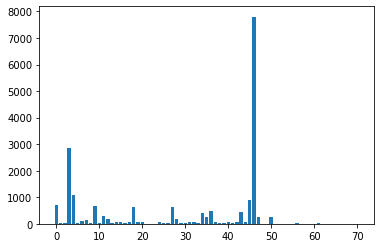

In [ ]:
import matplotlib.pyplot as plt

plt.bar(np.unique(y_train.argmax(axis=1),return_counts=True)[0],np.unique(y_train.argmax(axis=1),return_counts=True)[1])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

_, X_grid, _, y_grid= train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [ ]:
X_grid.shape

(1964, 1000, 12)

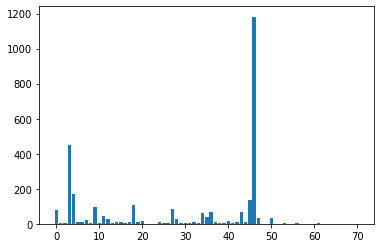

In [ ]:
plt.bar(np.unique(y_grid.argmax(axis=1),return_counts=True)[0],np.unique(y_grid.argmax(axis=1),return_counts=True)[1])
plt.show()

# Train or download models
There are two possibilities:
   1. Run the experiments as described in README. Afterwards you find trained in models in `output/expX/models/`
   2. Download the precomputed `output`-folder with all experiments and models from [here]((https://datacloud.hhi.fraunhofer.de/nextcloud/s/NCjYws3mamLrkKq))

# Load pretrained model

For loading a pretrained model:
   1. specify `modelname` which can be seen in `code/configs/` (e.g. `modelname='fastai_xresnet1d101'`)
   2. provide `experiment` to build the path `pretrainedfolder` (here: `exp0` refers to the experiment with `all` 71 SCP-statements)
   
This returns the pretrained model where the classification is replaced by a random initialized head with the same number of outputs as the number of classes.

In [ ]:
from github_repo.code.models.base_model import ClassificationModel
import tensorflow as tf
import numpy as np

def scheduler(epoch, lr):
    if epoch % 5 == 0:
        return lr*0.1
    else:
        return lr
        
class inception_time_model(ClassificationModel):
    def __init__(self, name, n_classes,  sampling_frequency, outputfolder, input_shape, epoch=30, batch_size=32, lr_init = 0.001, lr_red="yes", model_depth=6, loss="bce", kernel_size=40, bottleneck_size=32, nb_filters=32, clf="binary"):
        super(inception_time_model, self).__init__()
        self.name = name
        self.n_classes = n_classes
        self.sampling_frequency = sampling_frequency
        self.outputfolder = outputfolder
        self.input_shape = input_shape
        self.model = build_model((self.sampling_frequency*10,12),self.n_classes,lr_init = 0.001, depth=model_depth, kernel_size=40, bottleneck_size=32, nb_filters=32,clf="binary")
        self.epoch = epoch 
        self.batch_size = batch_size
        self.lr_red = lr_red
        self.loss = loss
        

    def fit(self, X_train, y_train, X_val, y_val):
        self.model.fit(X_train, y_train, epochs=self.epoch, batch_size=self.batch_size, 
        validation_data=(X_val, y_val), 
        callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
        ])
        #self.model.save(self.outputfolder +'last_model.h5')
    def predict(self, X):
        return self.model.predict(X)


def _inception_module(input_tensor, stride=1, activation='linear', use_bottleneck=True, kernel_size=40, bottleneck_size=32, nb_filters=32):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(filters=bottleneck_size, kernel_size=1,
                                              padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i],
                                              strides=stride, padding='same', activation=activation, use_bias=False)(
            input_inception))

    max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

    conv_6 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=1,
                                  padding='same', activation=activation, use_bias=False)(max_pool_1)

    conv_list.append(conv_6)

    x = tf.keras.layers.Concatenate(axis=2)(conv_list)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation='relu')(x)
    return x

def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = tf.keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                      padding='same', use_bias=False)(input_tensor)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    x = tf.keras.layers.Add()([shortcut_y, out_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def build_model(input_shape, nb_classes, depth=6, use_residual=True, lr_init = 0.001, kernel_size=40, bottleneck_size=32, nb_filters=32, clf="binary"):
    input_layer = tf.keras.layers.Input(input_shape)

    x = input_layer
    input_res = input_layer

    for d in range(depth):

        x = _inception_module(x,kernel_size = kernel_size, bottleneck_size=bottleneck_size, nb_filters=nb_filters)

        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)

    output_layer = tf.keras.layers.Dense(units=nb_classes,activation='sigmoid')(gap_layer)  
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=lr_init), 
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                           tf.keras.metrics.AUC(
                        num_thresholds=200,
                        curve='ROC',
                        summation_method='interpolation',
                        name="ROC",
                        multi_label=True,
                        ),
                       tf.keras.metrics.AUC(
                        num_thresholds=200,
                        curve='PR',
                        summation_method='interpolation',
                        name="PRC",
                        multi_label=True,
                        )
              ])
    print("Inception model built.")
    return model




In [ ]:
model.model.loss

In [ ]:
from github_repo.code.models.base_model import ClassificationModel
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa

        
class inception_time_model(ClassificationModel):
    def __init__(self, name, n_classes,  sampling_frequency, outputfolder, input_shape, epoch=30, batch_size=32, lr_init = 0.001, lr_red="yes", model_depth=6, loss="bce", kernel_size=40, bottleneck_size=32, nb_filters=32, clf="binary", verbose=0):
        super(inception_time_model, self).__init__()
        self.name = name
        self.n_classes = n_classes
        self.sampling_frequency = sampling_frequency
        self.outputfolder = outputfolder
        self.input_shape = input_shape
        if loss == "bce":
          self.loss = tf.keras.losses.BinaryCrossentropy()
        elif loss == "wbce":
          self.loss = tfa.losses.SigmoidFocalCrossEntropy() #focal instead of weighted bce
        self.model = build_modelol((self.sampling_frequency*10,12),self.n_classes,lr_init = lr_init, depth=model_depth, kernel_size=kernel_size, bottleneck_size=bottleneck_size, nb_filters=nb_filters,clf=clf, loss=self.loss)
        self.epoch = epoch
        self.batch_size = batch_size
        self.lr_red = lr_red
        self.verbose = verbose

        
        

    def fit(self, X_train, y_train, X_val, y_val):

        if self.lr_red == "no":
            self.model.fit(X_train, y_train, epochs=self.epoch, batch_size=self.batch_size, 
            validation_data=(X_val, y_val), verbose=self.verbose)
        elif self.lr_red == "yes":
            self.model.fit(X_train, y_train, epochs=self.epoch, batch_size=self.batch_size, 
            validation_data=(X_val, y_val), verbose=self.verbose,
            callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)])
        else:
            print("Error: wrong lr_red argument")

        #self.model.save(self.outputfolder +'last_model.h5')
    def predict(self, X):
        return self.model.predict(X)


def _inception_module(input_tensor, stride=1, activation='linear', use_bottleneck=True, kernel_size=40, bottleneck_size=32, nb_filters=32):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(filters=bottleneck_size, kernel_size=1,
                                              padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i],
                                              strides=stride, padding='same', activation=activation, use_bias=False)(
            input_inception))

    max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

    conv_6 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=1,
                                  padding='same', activation=activation, use_bias=False)(max_pool_1)

    conv_list.append(conv_6)

    x = tf.keras.layers.Concatenate(axis=2)(conv_list)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation='relu')(x)
    return x

def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = tf.keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                      padding='same', use_bias=False)(input_tensor)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    x = tf.keras.layers.Add()([shortcut_y, out_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def build_modelol(input_shape, nb_classes, depth=6, use_residual=True, lr_init = 0.001, kernel_size=40, bottleneck_size=32, nb_filters=32, clf="binary", loss=tf.keras.losses.BinaryCrossentropy()):
    input_layer = tf.keras.layers.Input(input_shape)

    x = input_layer
    input_res = input_layer

    for d in range(depth):

        x = _inception_module(x,kernel_size = kernel_size, bottleneck_size=bottleneck_size, nb_filters=nb_filters)

        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)

    output_layer = tf.keras.layers.Dense(units=nb_classes,activation='sigmoid')(gap_layer)  
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr_init), 
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.AUC(
                        num_thresholds=200,
                        curve='ROC',
                        summation_method='interpolation',
                        name="ROC",
                        multi_label=True,
                        ),
                      tf.keras.metrics.AUC(
                        num_thresholds=200,
                        curve='PR',
                        summation_method='interpolation',
                        name="PRC",
                        multi_label=True,
                        )
              ])
    print("Inception model built.")
    return model

def scheduler(epoch, lr):
    if epoch % 5 == 0:
        return lr*0.1
    else:
        return lr


In [ ]:
#from github_repo.code.models.your_model import inception_time_model

# change first line in your_model.py to from github_repo.code.models.base_model import ClassificationModel

experiment = 'exp0'
modelname = 'fastai_xresnet1d101'
pretrainedfolder = '../output/'+experiment+'/models/'+modelname+'/'
mpath='../output/' # <=== path where the finetuned model will be stored
n_classes_pretrained = 71 # <=== because we load the model from exp0, this should be fixed because this depends the experiment

model = inception_time_model("tf_inception", num_classes, sampling_frequency, mpath, input_shape)

#model = fastai_model(
#    modelname, 
#    num_classes, 
#    sampling_frequency, 
#    mpath, 
#    input_shape=input_shape, 
#    pretrainedfolder=pretrainedfolder,
#    n_classes_pretrained=n_classes_pretrained, 
#    pretrained=True,
#    epochs_finetuning=2,
#)

Inception model built.












# Preprocess data with pretrained Standardizer

Since we standardize inputs to zero mean and unit variance, your custom data needs to be standardized with the respective mean and variance. This is also provided in the respective experiment folder `output/expX/data/standard_scaler.pkl`

In [ ]:
import pickle
from github_repo.code.utils import utils

#standard_scaler = pickle.load(open('./github_repo/output/'+experiment+'/data/standard_scaler.pkl', "rb"))

#X_grid = utils.apply_standardizer(X_grid, standard_scaler)
#X_val = utils.apply_standardizer(X_val, standard_scaler)

In [ ]:
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

def apply_standardizer(X, ss):
    X_tmp = []
    for x in X:
        x_shape = x.shape
        X_tmp.append(ss.transform(x.flatten()[:,np.newaxis]).reshape(x_shape))
    X_tmp = np.array(X_tmp)
    return X_tmp

def preprocess_signals(X_train, X_validation):
    # Standardize data such that mean 0 and variance 1
    ss = StandardScaler()
    ss.fit(np.vstack(X_train).flatten()[:,np.newaxis].astype(float))
  
    return apply_standardizer(X_train, ss), apply_standardizer(X_validation, ss)


# Finetune model

Calling `model.fit` of a model with `pretrained=True` will perform finetuning as proposed in our work i.e. **gradual unfreezing and discriminative learning rates**. 

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
df_grid = pd.read_csv("/content/gridsearch_params.csv")
df_score = pd.read_csv("/content/gridsearch_scores.csv")
gs_left = df_grid.shape[0] - df_score.shape[0] # run only the remaining gridsearch
init_rows = df_score.shape[0]

for gsr in range(gs_left):
  gsr = gsr + init_rows #if previous gridsearch results exists
  print("Running gridsearch nr {} of {}...".format(gsr,df_grid.shape[0]))
  auc_score = []
  for i, (train_index, test_index) in enumerate(skf.split(X_grid, y_grid.argmax(axis=1))):
    model = inception_time_model(name="tf_inception", n_classes=num_classes, sampling_frequency=sampling_frequency, outputfolder=mpath, input_shape=input_shape, 
                              epoch=int(df_grid.iloc[gsr]["epochs"]), batch_size=int(df_grid.iloc[gsr]["batch_size"]), lr_init = df_grid.iloc[gsr]["init_lr"],
                              lr_red=df_grid.iloc[gsr]["lr_red"], model_depth=int(df_grid.iloc[gsr]["model_depth"]), loss=df_grid.iloc[gsr]["loss"], 
                              kernel_size=int(df_grid.iloc[gsr]["kernel_size"].split(",")[0].split("(")[1]))
    cv_x_train = X_grid[train_index]
    cv_y_train = y_grid[train_index] 
    cv_x_test = X_grid[test_index]
    cv_y_test = y_grid[test_index]
    cv_x_train,cv_x_test = preprocess_signals(cv_x_train,cv_x_test)

    model.fit(cv_x_train, cv_y_train, cv_x_test, cv_y_test)
    y_hat_test = model.predict(cv_x_test)
    score=utils.evaluate_experiment(np.vstack([cv_y_test,np.ones(cv_y_test.shape[1])]), np.vstack([y_hat_test,np.ones(y_hat_test.shape[1])]))
    auc_score.append(score)
    print("Score CV {} : {} (AUROC score)".format(i+1,score))
  df_grid.loc[gsr, 'auc'] = np.asarray(auc_score).mean()
  df_score=df_score.append(df_grid.loc[gsr])
df_score.to_csv("gridsearch_scores_updated.csv", index=False)  

Running gridsearch nr 0 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 18ms/step
Score CV 1 :    macro_auc
0   0.785309 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 17ms/step
Score CV 2 :    macro_auc
0   0.804568 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 17ms/step
Score CV 3 :    macro_auc
0   0.791498 (AUROC score)
Running gridsearch nr 1 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 18ms/step
Score CV 1 :    macro_auc
0    0.81849 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 2 :    macro_auc
0   0.820807 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 3 :    macro_auc
0   0.821093 (AUROC score)
Running gridsearch nr 2 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 1 :    macro_auc
0    0.83337 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 2 :    macro_auc
0   0.821804 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 3 :    macro_auc
0   0.837105 (AUROC score)
Running gridsearch nr 3 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 17ms/step
Score CV 1 :    macro_auc
0   0.773381 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 18ms/step
Score CV 2 :    macro_auc
0   0.748142 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 18ms/step
Score CV 3 :    macro_auc
0   0.726756 (AUROC score)
Running gridsearch nr 4 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 1 :    macro_auc
0   0.820982 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 2 :    macro_auc
0   0.778317 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 3 :    macro_auc
0   0.819262 (AUROC score)
Running gridsearch nr 5 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 1 :    macro_auc
0   0.824672 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 2 :    macro_auc
0   0.789657 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 3 :    macro_auc
0   0.812811 (AUROC score)
Running gridsearch nr 6 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 26ms/step
Score CV 1 :    macro_auc
0   0.821719 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 26ms/step
Score CV 2 :    macro_auc
0    0.81206 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 26ms/step
Score CV 3 :    macro_auc
0   0.794849 (AUROC score)
Running gridsearch nr 7 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 28ms/step
Score CV 1 :    macro_auc
0   0.836565 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 28ms/step
Score CV 2 :    macro_auc
0   0.803726 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 28ms/step
Score CV 3 :    macro_auc
0   0.817623 (AUROC score)
Running gridsearch nr 8 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 29ms/step
Score CV 1 :    macro_auc
0   0.834711 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 29ms/step
Score CV 2 :    macro_auc
0   0.805836 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 29ms/step
Score CV 3 :    macro_auc
0   0.825461 (AUROC score)
Running gridsearch nr 9 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 26ms/step
Score CV 1 :    macro_auc
0   0.796138 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 26ms/step
Score CV 2 :    macro_auc
0   0.749337 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 26ms/step
Score CV 3 :    macro_auc
0   0.804074 (AUROC score)
Running gridsearch nr 10 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 32ms/step
Score CV 1 :    macro_auc
0   0.836407 (AUROC score)
Inception model built.
21/21 [==============================] - 2s 28ms/step
Score CV 2 :    macro_auc
0   0.806131 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 28ms/step
Score CV 3 :    macro_auc
0   0.793941 (AUROC score)
Running gridsearch nr 11 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 29ms/step
Score CV 1 :    macro_auc
0   0.805754 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 29ms/step
Score CV 2 :    macro_auc
0    0.79209 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 29ms/step
Score CV 3 :    macro_auc
0   0.808169 (AUROC score)
Running gridsearch nr 12 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 35ms/step
Score CV 1 :    macro_auc
0   0.816178 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 35ms/step
Score CV 2 :    macro_auc
0    0.78194 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 35ms/step
Score CV 3 :    macro_auc
0    0.81159 (AUROC score)
Running gridsearch nr 13 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 2s 38ms/step
Score CV 1 :    macro_auc
0    0.82238 (AUROC score)
Inception model built.
21/21 [==============================] - 2s 38ms/step
Score CV 2 :    macro_auc
0   0.825624 (AUROC score)
Inception model built.
21/21 [==============================] - 2s 38ms/step
Score CV 3 :    macro_auc
0   0.807163 (AUROC score)
Running gridsearch nr 14 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 2s 39ms/step
Score CV 1 :    macro_auc
0   0.823611 (AUROC score)
Inception model built.
21/21 [==============================] - 2s 39ms/step
Score CV 2 :    macro_auc
0   0.799625 (AUROC score)
Inception model built.
21/21 [==============================] - 2s 39ms/step
Score CV 3 :    macro_auc
0   0.829105 (AUROC score)
Running gridsearch nr 15 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 2s 35ms/step
Score CV 1 :    macro_auc
0   0.775262 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 36ms/step
Score CV 2 :    macro_auc
0   0.758773 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 35ms/step
Score CV 3 :    macro_auc
0   0.803473 (AUROC score)
Running gridsearch nr 16 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 2s 38ms/step
Score CV 1 :    macro_auc
0   0.823635 (AUROC score)
Inception model built.
21/21 [==============================] - 2s 38ms/step
Score CV 2 :    macro_auc
0   0.776986 (AUROC score)
Inception model built.
21/21 [==============================] - 2s 38ms/step
Score CV 3 :    macro_auc
0   0.804917 (AUROC score)
Running gridsearch nr 17 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 2s 39ms/step
Score CV 1 :    macro_auc
0   0.816949 (AUROC score)
Inception model built.
21/21 [==============================] - 2s 39ms/step
Score CV 2 :    macro_auc
0   0.772254 (AUROC score)
Inception model built.
21/21 [==============================] - 2s 39ms/step
Score CV 3 :    macro_auc
0    0.82311 (AUROC score)
Running gridsearch nr 18 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 2s 17ms/step
Score CV 1 :    macro_auc
0    0.88794 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 18ms/step
Score CV 2 :    macro_auc
0    0.86945 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 18ms/step
Score CV 3 :    macro_auc
0   0.888054 (AUROC score)
Running gridsearch nr 19 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 1 :    macro_auc
0   0.895454 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 2 :    macro_auc
0   0.870784 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 3 :    macro_auc
0    0.88359 (AUROC score)
Running gridsearch nr 20 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 1 :    macro_auc
0    0.87756 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 2 :    macro_auc
0   0.879005 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 20ms/step
Score CV 3 :    macro_auc
0   0.879999 (AUROC score)
Running gridsearch nr 21 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 18ms/step
Score CV 1 :    macro_auc
0   0.882987 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 18ms/step
Score CV 2 :    macro_auc
0   0.869587 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 18ms/step
Score CV 3 :    macro_auc
0   0.883509 (AUROC score)
Running gridsearch nr 22 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 1 :    macro_auc
0   0.866746 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 2 :    macro_auc
0   0.870394 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 3 :    macro_auc
0   0.886791 (AUROC score)
Running gridsearch nr 23 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 1 :    macro_auc
0   0.876125 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 20ms/step
Score CV 2 :    macro_auc
0   0.860956 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 19ms/step
Score CV 3 :    macro_auc
0   0.875806 (AUROC score)
Running gridsearch nr 24 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 26ms/step
Score CV 1 :    macro_auc
0   0.888203 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 26ms/step
Score CV 2 :    macro_auc
0   0.881306 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 27ms/step
Score CV 3 :    macro_auc
0   0.887909 (AUROC score)
Running gridsearch nr 25 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 28ms/step
Score CV 1 :    macro_auc
0   0.882829 (AUROC score)
Inception model built.
21/21 [==============================] - 2s 28ms/step
Score CV 2 :    macro_auc
0   0.880861 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 28ms/step
Score CV 3 :    macro_auc
0   0.895306 (AUROC score)
Running gridsearch nr 26 of 972...


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Inception model built.
21/21 [==============================] - 1s 29ms/step
Score CV 1 :    macro_auc
0   0.880683 (AUROC score)
Inception model built.
21/21 [==============================] - 1s 29ms/step
Score CV 2 :    macro_auc
0   0.879229 (AUROC score)
Inception model built.


KeyboardInterrupt: ignored

In [ ]:
df_score.to_csv("gridsearch_scores_updated.csv", index=False)  

# Evaluate model on validation data